# Iperf data loading
This notebook reads and aligns data generated from multi-client iperf experiments into a single timeseries that shows the combined throughput of all clients

In [5]:
%matplotlib notebook

In [6]:
import json
import os
import numpy as np
import pandas as pd
from glob import glob

DIV = 1e9

def lenient_read_json(file):
    '''Sometimes the json files output by iperf3 have one error message at the top.
    This function discards that error message and parses the rest of the file'''
    try:
        return json.load(open(file))
    except Exception as e:
        print("Malformed json {}: {}".format(file, e))
        lines = '\n'.join(open(file).readlines()[1:])
        return json.loads(lines)

Different iperf sessions might start at slightly different times. To fix this, the iperf sessions are aligned with one another using a timestamp output by the server when the client successfully connects.

In [189]:
def read_iperf_feature(directory, feature='bits_per_second'):
    # Read the Shremote log file to get the time at which the client connected
    try:
        event_log = json.load(open(os.path.join(directory, 'event_log.json')))
        client_entry= [e for e in event_log if e['name_'] == 'iperf_client'][0]
        iperf_time= client_entry['time']
    except IOError:
        print("{} Event log not found".format(directory))
        return None
    
    # For each server output, get the time at which the client successfully connected
    server_files = glob(os.path.join(directory,'iperf','server_*.out'))
    starts = {}
    for server_file in server_files:
        num = int(server_file.split('_')[-1][:-4])
        for line in open(server_file):
            if 'Accepted connection' in line:
                starts[num] = (float(line.split()[0]))
                break
        else:
            print("Could not find Accepted connection in {}".format(server_file))
           
    # The amount of usable time in the experiments is that for which
    # all of the clients were running simultaneously
    min_start = min(starts.values())
    max_start = max(starts.values())
    usable_time = iperf_time - (max_start - min_start)
            
    client_base = os.path.join(directory, 'iperf', 'client_%d.json')
    
    per_client_bps = []
    
    # Read each client file and extract the throughputs during the usable interval
    for i, start in starts.items():
        offset = max_start - start
        if offset > .05:
            print("Offset of file %d is %f" % (i, offset))
        client_bps = []
        client_file = client_base % i
        client = lenient_read_json(client_file)
        for interval in client['intervals']:
            if len(interval['streams']) == 0:
                break
            interval = interval['streams'][0]
            if interval['end'] >= offset and interval['end'] < (usable_time + offset):
                client_bps.append(interval[feature])
        
        if len(client_bps) > 0:
            per_client_bps.append(client_bps)
        
    # Lengths might differ by 1 due to rounding errors.
    # Take the smallest timeseries and truncate all to that length
    minlen = min([len(b) for b in per_client_bps])
    per_client_bps = [bps[:minlen] for bps in per_client_bps]    
        
    # Sum the results
    all_bps = np.array(per_client_bps)
    if feature == 'rtt':
        summed_bps = all_bps.mean(axis=0)
    else:
        summed_bps = all_bps.sum(axis=0)
    timestamps = np.arange(0, len(summed_bps) / 10, .1)
    return pd.DataFrame({'time': timestamps, 'value': summed_bps})

## Data Aggregation
Reads a series of experiments located in the same base directory

In [146]:
def read_iperf_experiments(base_dir, experiments, labels, feature='bits_per_second'):
    data = []
    for exp in experiments:
        for label in labels:
            df = read_iperf_feature(os.path.join(base_dir, exp, '%s_%s' % (exp, label)), feature)
            df.value /= 1e6
            data.append(df.assign(experiment=exp, trial=label))
    return pd.concat(data, ignore_index=True)

In [190]:
hc_14 = read_iperf_experiments('../e2e_output_500k_cpu_hc_14', ['baseline', 'hc', 'drop', 'fec', 'kv'], [1,2,3,4,5])

Could not find Accepted connection in ../e2e_output_500k_cpu_hc_14/drop/drop_1/iperf/server_8.out
Could not find Accepted connection in ../e2e_output_500k_cpu_hc_14/drop/drop_1/iperf/server_0.out
Offset of file 2 is 0.168048
Offset of file 6 is 0.168071
Offset of file 3 is 0.168063
Offset of file 9 is 0.167912
Offset of file 4 is 0.168023
Malformed json ../e2e_output_500k_cpu_hc_14/drop/drop_1/iperf/client_4.json: Expecting value: line 1 column 1 (char 0)
Offset of file 1 is 0.168050
Offset of file 5 is 0.168119
Offset of file 7 is 1.016042
Offset of file 6 is 1.016129
Offset of file 3 is 1.016071
Offset of file 8 is 1.016089
Offset of file 9 is 0.840090
Offset of file 4 is 1.016048
Offset of file 1 is 1.015935
Offset of file 0 is 1.016068
Offset of file 5 is 1.016132
Offset of file 2 is 1.032010
Offset of file 7 is 1.032008
Offset of file 6 is 1.031919
Offset of file 8 is 1.032054
Offset of file 9 is 1.024040
Offset of file 4 is 1.031961
Offset of file 0 is 1.031966
Offset of file 5 i

In [28]:
EXPERIMENTS = ['baseline', 'hc', 'drop', 'fec', 'kv']

ARISTA_BASE = '../e2e_output_500k_arista_no_passthrough_2/'
TOFINO_BASE = '../e2e_output_500k_tofino_hc_14'
FPGA_BASE = '../e2e_output_500k_fpga_hc_14'
CPU_BASE = '../e2e_output_500k_cpu_hc_11'


BASE_DIRS = dict(
    arista = ARISTA_BASE,
    tofino = TOFINO_BASE,
    fpga = FPGA_BASE,
    cpu = CPU_BASE
)

TRIALS = list(range(1, 6))

In [158]:
import pickle
DEFAULT_FEATURE='bits_per_second'

def save_device_data(dev, experiments=EXPERIMENTS, feature=DEFAULT_FEATURE):
    '''A short-hand function to load the experiments associated with a given device'''
    data = read_iperf_experiments(BASE_DIRS[dev], experiments, TRIALS, feature)
    
    if feature != DEFAULT_FEATURE:
        label = '_%s'%feature
    else:
        label =''
        
    pickle.dump(data, open("%s_iperf%s.pickle" % (dev, label), 'wb'))
    return data

In [161]:
arista_data = save_device_data('arista')
tofino_data = save_device_data('tofino')
fpga_data = save_device_data('fpga')
cpu_data = save_device_data('cpu', ['baseline', 'hc'])

Could not find Accepted connection in ../e2e_output_500k_arista_no_passthrough_2/drop/drop_1/iperf/server_1.out
Offset of file 2 is 0.209620
Offset of file 7 is 0.205428
Offset of file 6 is 0.205573
Offset of file 3 is 0.205563
Offset of file 8 is 0.205594
Offset of file 9 is 0.205595
Offset of file 4 is 0.205548
Offset of file 5 is 0.205455
Offset of file 2 is 0.422002
Offset of file 7 is 0.418110
Offset of file 6 is 0.417898
Offset of file 8 is 0.417996
Offset of file 9 is 0.418032
Offset of file 4 is 0.418013
Offset of file 1 is 0.421927
Offset of file 0 is 0.421917
Offset of file 5 is 0.418008
Offset of file 2 is 0.213588
Offset of file 7 is 0.209678
Offset of file 3 is 0.213698
Offset of file 8 is 0.209572
Offset of file 9 is 0.209802
Offset of file 4 is 0.209732
Offset of file 1 is 0.213579
Offset of file 0 is 0.213680
Offset of file 5 is 0.209686
Offset of file 2 is 0.213656
Offset of file 7 is 0.209669
Offset of file 6 is 0.209650
Offset of file 3 is 0.213682
Offset of file 4 i

In [159]:
arista_data = save_device_data('arista', feature='rtt')
tofino_data = save_device_data('tofino', feature='rtt')
fpga_data = save_device_data('fpga', feature='rtt')
cpu_data = save_device_data('cpu', ['baseline', 'hc'], feature='rtt')

Could not find Accepted connection in ../e2e_output_500k_arista_no_passthrough_2/drop/drop_1/iperf/server_1.out
Offset of file 2 is 0.209620
Offset of file 7 is 0.205428
Offset of file 6 is 0.205573
Offset of file 3 is 0.205563
Offset of file 8 is 0.205594
Offset of file 9 is 0.205595
Offset of file 4 is 0.205548
Offset of file 5 is 0.205455
Offset of file 2 is 0.422002
Offset of file 7 is 0.418110
Offset of file 6 is 0.417898
Offset of file 8 is 0.417996
Offset of file 9 is 0.418032
Offset of file 4 is 0.418013
Offset of file 1 is 0.421927
Offset of file 0 is 0.421917
Offset of file 5 is 0.418008
Offset of file 2 is 0.213588
Offset of file 7 is 0.209678
Offset of file 3 is 0.213698
Offset of file 8 is 0.209572
Offset of file 9 is 0.209802
Offset of file 4 is 0.209732
Offset of file 1 is 0.213579
Offset of file 0 is 0.213680
Offset of file 5 is 0.209686
Offset of file 2 is 0.213656
Offset of file 7 is 0.209669
Offset of file 6 is 0.209650
Offset of file 3 is 0.213682
Offset of file 4 i

### Sample data plotting
plotting some sample data from the experiments for quick validation of expectations

In [173]:
import matplotlib.pyplot as plt

def plot_experiments(df, *args, roll=None,**kwargs):
    handles = []
    for exp, egroup in df.groupby('experiment'):
        color = None
        for trial, group in egroup.groupby('trial'):
            group = group.sort_values('time')
            if roll:
                group = group.rolling(roll*10, on='time')[['time', 'value']].mean()
            h = plt.plot(group.time, group.value*1e-3, *args, label=exp, color=color, **kwargs)
            color = h[0].get_color()
        handles.append(h[0])

    plt.legend(handles=handles)

<IPython.core.display.Javascript object>


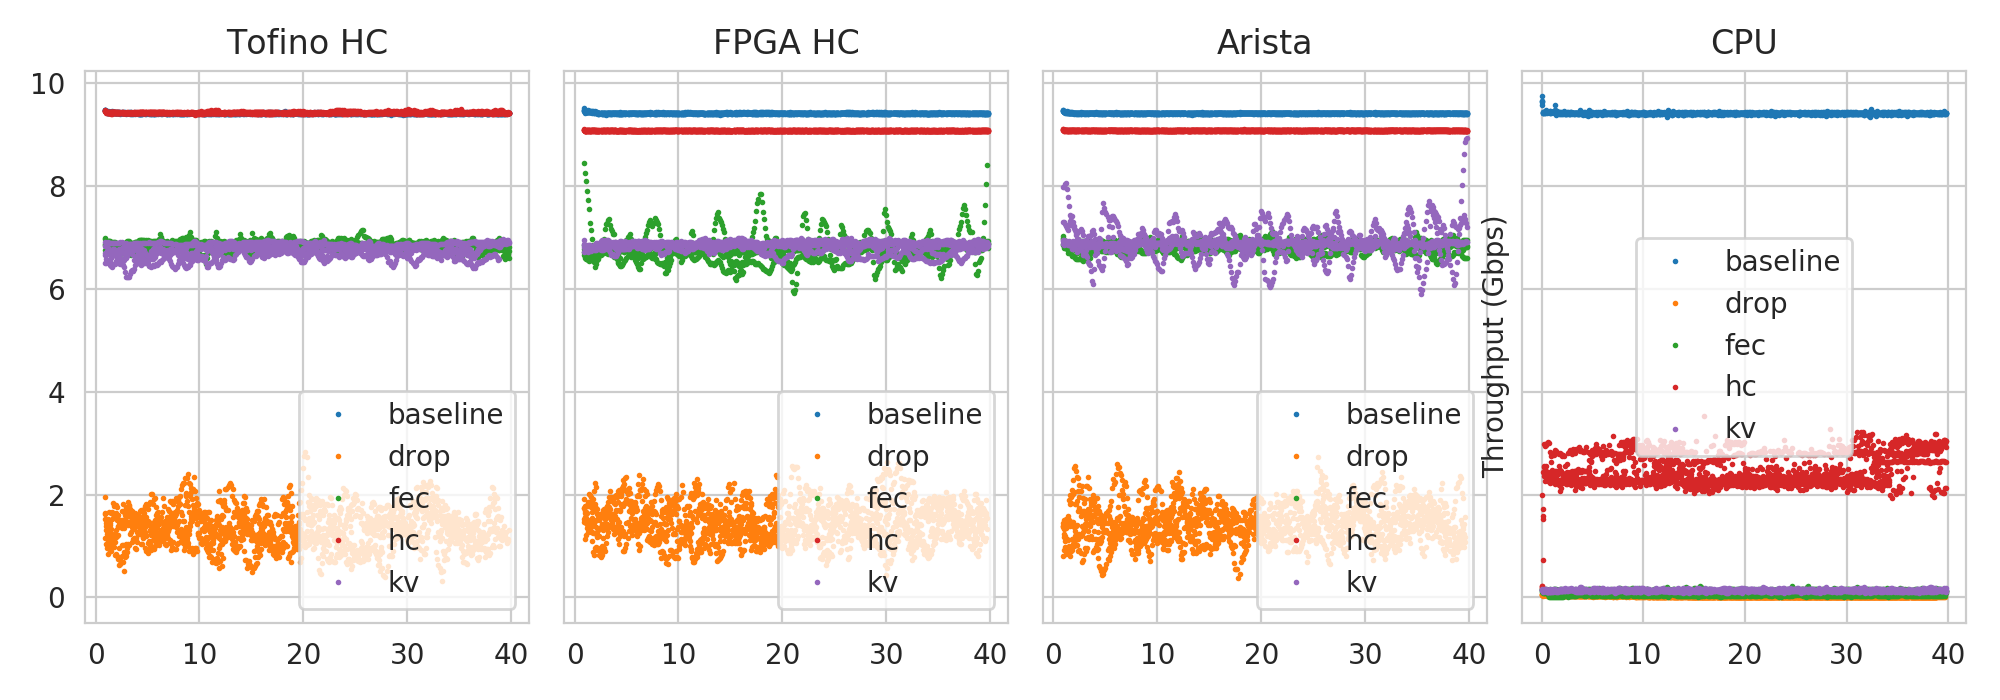

Text(725.9661835748793, 0.5, 'Throughput (Gbps)')

In [191]:
import seaborn as sns
sns.set_style("whitegrid")

roll=1

fig, axs = plt.subplots(1, 4, figsize=(10, 3.5), sharey=True, squeeze=False)
plt.sca(axs[0][0])
plot_experiments(tofino_data, '.', markersize=2, roll=roll)
plt.title("Tofino HC")

plt.sca(axs[0][1])
plot_experiments(fpga_data, '.', markersize=2, roll=roll)
plt.title("FPGA HC")

plt.sca(axs[0][2])
plot_experiments(arista_data, '.', markersize=2, roll=roll)
plt.title("Arista")

plt.sca(axs[0][3])
plot_experiments(hc_14, '.', markersize=2, roll=None)
# plot_experiments(cpu_data, '.', markersize=2, roll=None)

plt.title("CPU")
plt.tight_layout()

plt.ylabel("Throughput (Gbps)")
# plt.ylim([0, 10.5e3])

<IPython.core.display.Javascript object>


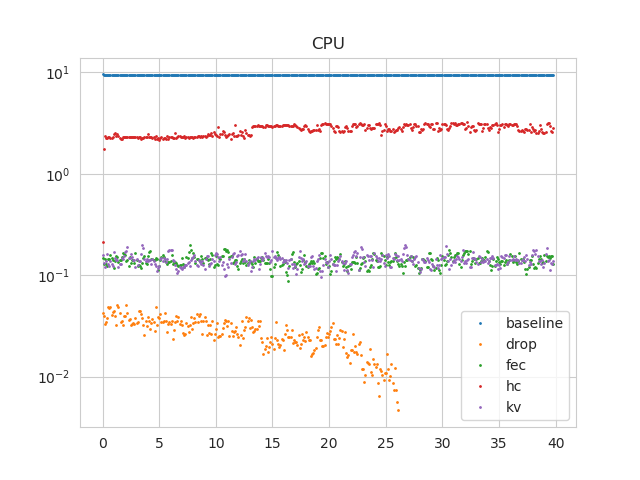

In [184]:
plt.figure()
plot_experiments(hc_14, '.', markersize=2, roll=None)
plt.title("CPU")
plt.yscale("log")

In [17]:
     
def plot_group_stat(df, axs, column='value', start_time = 0, stop_time = 100, experiments=EXPERIMENTS):
    df = df[(df.time > start_time) & (df.time < stop_time)]
    for ax, experiment in zip(axs, experiments):
        plt.sca(ax)
        df_exp = df[df.experiment == experiment]
        grouped = df_exp.groupby('trial')[column]
        latencies = grouped.median()
        lows, highs = grouped.quantile(.01), grouped.quantile(.99)
        plt.errorbar(latencies.index, latencies, yerr=[latencies-lows, highs-latencies], 
                     fmt='o', fillstyle='none')
        plt.title(experiment)

<IPython.core.display.Javascript object>


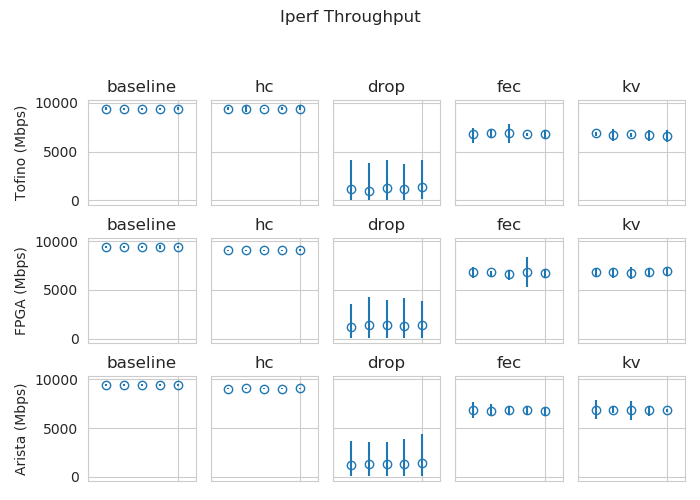

In [21]:
%matplotlib notebook
fig, axs = plt.subplots(3, len(EXPERIMENTS), squeeze=False, sharey=True, sharex=True, figsize=(7,5))

plot_group_stat(tofino_data, axs[0,:], start_time=5, stop_time=35)
axs[0][0].set_ylabel("Tofino (Mbps)")

plot_group_stat(fpga_data, axs[1,:], start_time=5, stop_time=35)
axs[1][0].set_ylabel("FPGA (Mbps)")

plot_group_stat(arista_data, axs[2,:], start_time=5, stop_time=35)
axs[2][0].set_ylabel("Arista (Mbps)")


plt.suptitle("Iperf Throughput")
plt.xlim([0, 6])
axs[0][0].set_xticklabels([])
plt.tight_layout()
plt.subplots_adjust(top=.8)


In [142]:
def plot_timeseries(df, experiment):
    df = df[df.experiment == experiment]
    dfs = []
    for trial, tdf in df.groupby('trial'):
        tdf = tdf.sort_values('time')
        tdf['time'] = pd.to_timedelta(tdf['time'], 's')
        tdf = tdf.rolling(pd.Timedelta(1, 's'), on='time')[['time', 'value']].mean()
        tdf['time'] = tdf['time'].apply(lambda x: x.total_seconds())
        dfs.append(tdf.assign(trial=trial))
        
    df = pd.concat(dfs, ignore_index=True)
    max_df = df.groupby('time').max().reset_index()
    min_df = df.groupby('time').min().reset_index()
    median_df = df.groupby('time').median().reset_index()
    
    plt.fill_between(max_df.time, min_df.value, max_df.value, ls='-', edgecolor='face', alpha=.5)
    plt.plot(median_df.time, median_df.value)

In [143]:
a = pd.Timedelta(15, 's')
a.total_seconds()

15.0

<IPython.core.display.Javascript object>


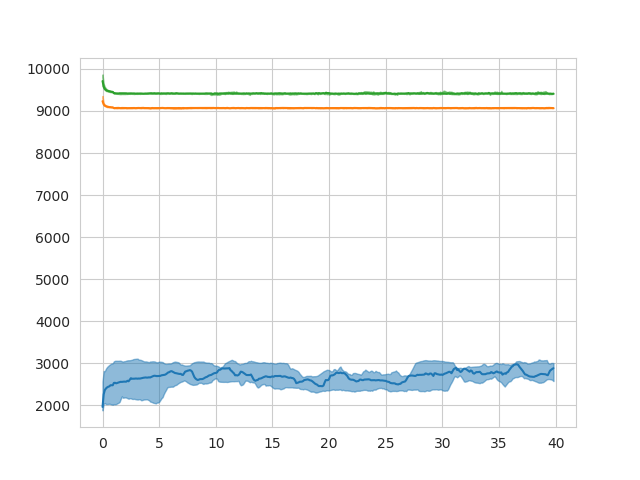

In [145]:
plt.figure()
plot_timeseries(cpu_data, 'hc')
plot_timeseries(fpga_data, 'hc')
plot_timeseries(tofino_data, 'hc')

In [130]:
plt.plot(a.time, b.value)

In [113]:
plt.plot(y.time, y.value)